In [1]:
import pyupbit
import pandas as pd
import pandas_datareader.data as web
import datetime
import numpy as np
import math
import time as timelibrary
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)

In [2]:
int(timelibrary.mktime(datetime.datetime.strptime('2021-04-08 01:00:00', '%Y-%m-%d %H:%M:%S').timetuple()))

1617811200

In [3]:
int(timelibrary.mktime(datetime.datetime.strptime('2017-09-26 17:00:00', '%Y-%m-%d %H:%M:%S').timetuple()))

1506412800

In [4]:
(1617811200 - 1506412800) / 14400

7736.0

In [7]:
# crypto: 암호화폐 티커
# interval: 캔들 종류
# num_candle: 거래 시그널 만들 때 사용할 캔들 수
# range_up: 채널 상단 범위
# range_down: 채널 하단 범위
# begin: 시작 시간
# end: 끝 시간

def backtester(crypto, interval, num_candle, range_up, range_down, begin, end):
    # 2017-09-26 17:00:00 -> 1506412800
    starttime = int(timelibrary.mktime(datetime.datetime.strptime(begin, '%Y-%m-%d %H:%M:%S').timetuple()))
    # 2021-04-08 01:00:00 -> 1617811200
    endtime = int(timelibrary.mktime(datetime.datetime.strptime(end, '%Y-%m-%d %H:%M:%S').timetuple()))
    # 봉 총 개수
    total_candle = (endtime - starttime) / 14400
    
    df_total = pd.DataFrame(columns=['open', 'high', 'low', 'close', 'volume'])
    
    # 봉 200개씩 가져올 수 있음 -> total_candle // 200 + 1
    num_chunk = int(total_candle // 200)
    
    for i in range(num_chunk + 1):
        df = pyupbit.get_ohlcv(crypto, interval=interval, to=datetime.datetime.fromtimestamp(starttime + (i+1) * 200 * 14400).strftime('%Y-%m-%d %H:%M:%S'))
        df_total = pd.concat([df_total, df])
    
    df_total['high_candle'] = df_total['high'].shift(1).rolling(window=num_candle).max()
    df_total['low_candle'] = df_total['low'].shift(1).rolling(window=num_candle).min()
    
    df_total['high_low_up'] = df_total['low_candle'] + range_up * (df_total['high_candle'] - df_total['low_candle'])
    df_total['high_low_down'] = df_total['low_candle'] + range_down * (df_total['high_candle'] - df_total['low_candle'])
    
    long = 0
    entry_price = 0
    exit_price = 0
    stop_loss_price = 0
    budget = 1000000
    position_size = 0
    win = 0
    lose = 0
    gross_profit = 0
    gross_loss = 0
    timestamp_budget = []
    labels = ['Date', 'Budget']
    
    # start point for graph
    timestamp_budget.append([df_total.index[num_candle], budget])
    
    for i in range(len(df_total)):
        if i >= num_candle:
            # long
            # low < high_low_up < high -> enter long position
            if df_total.iloc[i,7] < df_total.iloc[i,1] and df_total.iloc[i,7] > df_total.iloc[i,2]:
                # long signal on, no long position yet
                # long position activated and long signal on -> pass
                if long == 0:
                    # long state activate
                    long = 1
                    entry_price = df_total.iloc[i,7]
                    # 손절선 조절 가능
                    # 실거래를 5개 암호화폐 동일 비중으로 할 생각이라 1회 거래에서 총 자금의 2% 이상 잃지 않도록 10% 손절선 설정
                    stop_loss_price = entry_price * (1 - 0.1)
                    position_size = budget / entry_price
                    print("Date: ", df_total.index[i], "Long Entry: ", entry_price, "Size: ", position_size)
                    
            # stop loss on
            if long == 1 and stop_loss_price < df_total.iloc[i,1] and stop_loss_price > df_total.iloc[i,2]:
                exit_price = stop_loss_price
                # 슬리피지 1% 가정 (실제보다 보수적으로)
                pnl = (exit_price - entry_price) * position_size * (1 + 0.01)
                budget += pnl
                # graph point
                timestamp_budget.append([df_total.index[i], budget])
                gross_loss += pnl
                lose += 1
                print("Date: ", df_total.index[i], "Long stop loss ", "Profit or Loss: ", pnl)
                long = 0
                exit_price = 0
                entry_price = 0
                stop_loss_price = 0
                position_size = 0    
            
            # long position close rule on
            # low < high_low_down < high --> close long position
            if long == 1 and df_total.iloc[i,8] < df_total.iloc[i,1] and df_total.iloc[i,8] > df_total.iloc[i,2]:
                exit_price = df_total.iloc[i,8]
                # 슬리피지 1% 가정 (실제보다 보수적으로)
                pnl = (exit_price - entry_price) * position_size * (1 - 0.01)
                budget += pnl
                # graph point
                timestamp_budget.append([df_total.index[i], budget])
                
                if pnl > 0:
                    gross_profit += pnl
                    win += 1
                if pnl < 0:
                    gross_loss += pnl
                    lose += 1
                
                print("Date: ", df_total.index[i], "Long close ", "Profit or Loss: ", pnl)
                long = 0
                exit_price = 0
                entry_price = 0
                stop_loss_price = 0
                position_size = 0
                
    df_timestamp_budget = pd.DataFrame.from_records(timestamp_budget, columns=labels)
    df_timestamp_budget = df_timestamp_budget.set_index('Date')
    
    df_timestamp_budget.plot(title='Trend Following Strategy')
    
    return budget, (str(budget/1000000 * 100) + str('%')), win+lose, win/(win+lose), (gross_profit/win)/abs(gross_loss/lose)

Date:  2017-10-02 01:00:00 Long Entry:  225.6 Size:  4432.624113475177
Date:  2017-10-13 01:00:00 Long close  Profit or Loss:  258031.91489361692
Date:  2017-10-14 01:00:00 Long Entry:  300.2 Size:  4190.645952343827
Date:  2017-10-17 01:00:00 Long close  Profit or Loss:  -52274.117609536755
Date:  2017-10-29 13:00:00 Long Entry:  233.4 Size:  5166.05740053162
Date:  2017-10-29 17:00:00 Long close  Profit or Loss:  -24549.104767326317
Date:  2017-11-02 17:00:00 Long Entry:  228.4 Size:  5171.666779845683
Date:  2017-11-02 17:00:00 Long close  Profit or Loss:  -55295.4612101101
Date:  2017-11-03 05:00:00 Long Entry:  227.0 Size:  4959.970181967595
Date:  2017-11-04 09:00:00 Long close  Profit or Loss:  -6874.518672207114
Date:  2017-11-08 05:00:00 Long Entry:  235.8 Size:  4745.71124950991
Date:  2017-11-10 21:00:00 Long close  Profit or Loss:  -2818.952482208993
Date:  2017-11-13 13:00:00 Long Entry:  245.0 Size:  4555.999021029501
Date:  2017-11-13 13:00:00 Long close  Profit or Loss:

Date:  2018-12-22 21:00:00 Long close  Profit or Loss:  1064755.4185684465
Date:  2018-12-23 17:00:00 Long Entry:  424.4 Size:  16505.637020218128
Date:  2018-12-25 21:00:00 Long close  Profit or Loss:  -222231.89684021633
Date:  2018-12-30 05:00:00 Long Entry:  417.4 Size:  16250.025046814464
Date:  2019-01-01 01:00:00 Long close  Profit or Loss:  -434363.1695013506
Date:  2019-01-07 01:00:00 Long Entry:  407.6 Size:  15575.066940723764
Date:  2019-01-10 13:00:00 Long close  Profit or Loss:  -37006.35905116019
Date:  2019-01-14 21:00:00 Long Entry:  372.0 Size:  16966.104639752273
Date:  2019-01-17 21:00:00 Long close  Profit or Loss:  -178042.30208956075
Date:  2019-01-19 17:00:00 Long Entry:  371.4 Size:  16514.13199757212
Date:  2019-01-20 17:00:00 Long close  Profit or Loss:  -179838.89745356038
Date:  2019-01-30 21:00:00 Long Entry:  340.8 Size:  17469.218680882408
Date:  2019-02-03 21:00:00 Long close  Profit or Loss:  -148732.9278490332
Date:  2019-02-08 17:00:00 Long Entry:  3

Date:  2020-03-16 05:00:00 Long Entry:  203.8 Size:  33226.55274198538
Date:  2020-03-16 13:00:00 Long stop loss  Profit or Loss:  -683928.7163304785
Date:  2020-03-20 09:00:00 Long Entry:  208.6 Size:  29183.3304529537
Date:  2020-03-23 01:00:00 Long close  Profit or Loss:  -485377.15209352545
Date:  2020-03-24 17:00:00 Long Entry:  200.2 Size:  27983.34455740568
Date:  2020-03-30 05:00:00 Long close  Profit or Loss:  94191.93778022767
Date:  2020-03-31 21:00:00 Long Entry:  215.8 Size:  26396.930112015034
Date:  2020-04-06 01:00:00 Long close  Profit or Loss:  -36586.14513525299
Date:  2020-04-06 09:00:00 Long Entry:  218.6 Size:  25891.45184372183
Date:  2020-04-10 13:00:00 Long close  Profit or Loss:  353729.0150889279
Date:  2020-04-12 21:00:00 Long Entry:  237.8 Size:  25288.479344518582
Date:  2020-04-13 09:00:00 Long close  Profit or Loss:  -320455.61025373975
Date:  2020-04-16 17:00:00 Long Entry:  229.0 Size:  24860.89422651869
Date:  2020-04-20 21:00:00 Long close  Profit or

Date:  2021-03-13 21:00:00 Long Entry:  536.6 Size:  18297.495427045127
Date:  2021-03-15 09:00:00 Long close  Profit or Loss:  -485469.1486703615
Date:  2021-03-06 21:00:00 Long Entry:  526.4 Size:  17729.800337161956
Date:  2021-03-10 09:00:00 Long close  Profit or Loss:  154462.02053735615
Date:  2021-03-13 21:00:00 Long Entry:  536.6 Size:  17680.635329890807
Date:  2021-03-15 09:00:00 Long close  Profit or Loss:  -469102.6165726631
Date:  2021-03-16 09:00:00 Long Entry:  526.4 Size:  17132.078840134396
Date:  2021-03-25 05:00:00 Long close  Profit or Loss:  1400958.6150731505
Date:  2021-03-26 17:00:00 Long Entry:  686.4 Size:  15179.610892365816
Date:  2021-03-31 09:00:00 Long close  Profit or Loss:  -423784.37689306785
Date:  2021-04-01 05:00:00 Long Entry:  690.4 Size:  14477.83971556609


(9995500.539626827,
 '999.5500539626827%',
 180,
 0.2722222222222222,
 3.4493174738435655)

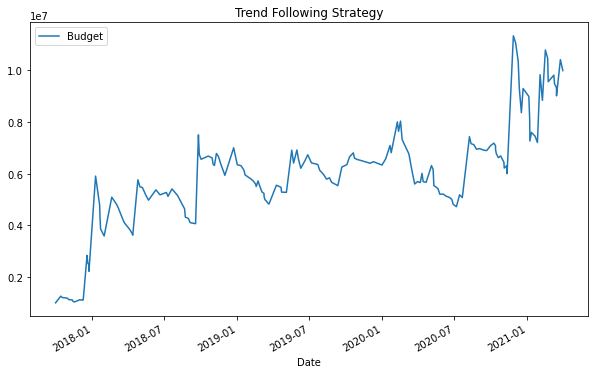

In [21]:
backtester("KRW-ETH", "minute240", 20, 0.8, 0.2, '2017-09-26 17:00:00', '2021-04-08 01:00:00')

In [9]:
# crypto: 암호화폐 티커
# interval: 캔들 종류
# num_candle: 거래 시그널 만들 때 사용할 캔들 수
# atr_candle: 샹들리에 청산 위한 atr 계산 시 사용할 캔들 수. 민첩한 움직임이 필요하니 num_candle보다는 짧게 가져갈 생각
# atr_mul: 고점 대비 몇 atr 하락 시 탈출할 것인지
# range_up: 채널 상단 범위
# range_down: 채널 하단 범위
# begin: 시작 시간
# end: 끝 시간

# 샹들리에 청산 추가 버전
def backtester_chandelier(crypto, interval, num_candle, atr_candle, atr_mul, range_up, range_down, begin, end):
    # 2017-09-26 17:00:00 -> 1506412800
    starttime = int(timelibrary.mktime(datetime.datetime.strptime(begin, '%Y-%m-%d %H:%M:%S').timetuple()))
    # 2021-04-08 01:00:00 -> 1617811200
    endtime = int(timelibrary.mktime(datetime.datetime.strptime(end, '%Y-%m-%d %H:%M:%S').timetuple()))
    # 봉 총 개수
    total_candle = (endtime - starttime) / 14400
    
    df_total = pd.DataFrame(columns=['open', 'high', 'low', 'close', 'volume'])
    
    # 봉 200개씩 가져올 수 있음 -> total_candle // 200 + 1
    num_chunk = int(total_candle // 200)
    
    for i in range(num_chunk + 1):
        df = pyupbit.get_ohlcv(crypto, interval=interval, to=datetime.datetime.fromtimestamp(starttime + (i+1) * 200 * 14400).strftime('%Y-%m-%d %H:%M:%S'))
        df_total = pd.concat([df_total, df])
    
    df_total['high_candle'] = df_total['high'].shift(1).rolling(window=num_candle).max()
    df_total['low_candle'] = df_total['low'].shift(1).rolling(window=num_candle).min()
    
    df_total['high_low_up'] = df_total['low_candle'] + range_up * (df_total['high_candle'] - df_total['low_candle'])
    df_total['high_low_down'] = df_total['low_candle'] + range_down * (df_total['high_candle'] - df_total['low_candle'])
    
    # 이전 봉 종가
    df_total['prev_close'] = df_total['close'].shift(1)
    
    # tr = max(abs(high - low), abs(high - prev_close), abs(low - prev_close))
    df_total['hml'] = df_total['high'] - df_total['low']
    df_total['hmprevc'] = abs(df_total['high'] - df_total['prev_close'])
    df_total['lmprevc'] = abs(df_total['low'] - df_total['prev_close'])
    df_total['tr'] = df_total.loc[:, ['hml','hmprevc','lmprevc']].max(axis=1)
    
    # atr(10) = exponential moving average(10) of tr
    df_total['atr'] = df_total['tr'].ewm(atr_candle).mean()
    
    long = 0
    entry_price = 0
    exit_price = 0
    stop_loss_price = 0
    budget = 1000000
    position_size = 0
    win = 0
    lose = 0
    gross_profit = 0
    gross_loss = 0
    timestamp_budget = []
    labels = ['Date', 'Budget']
    
    # start point for graph
    timestamp_budget.append([df_total.index[num_candle], budget])
    
    for i in range(len(df_total)):
        
        # ATR 구하는 과정에서 prev_close 구할 때 맨 위가 null인 것이나 atr이 atr_candle 만큼 지나기 전까지는 완전한 값이 아님
        # num_candle 만큼은 통과하고 시작하기 때문에 atr_candle < num_candle이기만 하면 괜찮음
        if i >= num_candle:
            # long
            # low < high_low_up < high -> enter long position
            if df_total.iloc[i,7] < df_total.iloc[i,1] and df_total.iloc[i,7] > df_total.iloc[i,2]:
                # long signal on, no long position yet
                # long position activated and long signal on -> pass
                if long == 0:
                    # long state activate
                    long = 1
                    entry_price = df_total.iloc[i,7]
                    # 손절선 조절 가능
                    # 실거래를 5개 암호화폐 동일 비중으로 할 생각이라 1회 거래에서 총 자금의 2% 이상 잃지 않도록 10% 손절선 설정
                    stop_loss_price = entry_price * (1 - 0.1)
                    position_size = budget / entry_price
                    print("Date: ", df_total.index[i], "Long Entry: ", entry_price, "Size: ", position_size)
                    
            # stop loss on
            if long == 1 and stop_loss_price < df_total.iloc[i,1] and stop_loss_price > df_total.iloc[i,2]:
                exit_price = stop_loss_price
                # 슬리피지 1% 가정 (실제보다 보수적으로)
                pnl = (exit_price - entry_price) * position_size * (1 + 0.01)
                budget += pnl
                # graph point
                timestamp_budget.append([df_total.index[i], budget])
                gross_loss += pnl
                lose += 1
                print("Date: ", df_total.index[i], "Long stop loss ", "Profit or Loss: ", pnl)
                long = 0
                exit_price = 0
                entry_price = 0
                stop_loss_price = 0
                position_size = 0    
            
            # long position close rule 1 on: 20% channel below breakout
            # low < high_low_down < high --> close long position
            if long == 1 and df_total.iloc[i,8] < df_total.iloc[i,1] and df_total.iloc[i,8] > df_total.iloc[i,2]:
                exit_price = df_total.iloc[i,8]
                # 슬리피지 1% 가정 (실제보다 보수적으로)
                pnl = (exit_price - entry_price) * position_size * (1 - 0.01)
                budget += pnl
                # graph point
                timestamp_budget.append([df_total.index[i], budget])
                
                if pnl > 0:
                    gross_profit += pnl
                    win += 1
                if pnl < 0:
                    gross_loss += pnl
                    lose += 1
                
                print("Date: ", df_total.index[i], "Long close ", "Profit or Loss: ", pnl)
                long = 0
                exit_price = 0
                entry_price = 0
                stop_loss_price = 0
                position_size = 0
            
            # long position close rule 2 on: highest - atr_mul * atr 밑으로 갈 때
            # num_candle 동안 고가: index 5, atr: index 14
            # low < highest - 3 * atr < high --> close long position by chandelier exit
            if long == 1 and (df_total.iloc[i,5] - atr_mul * df_total.iloc[i,14]) < df_total.iloc[i,1] and (df_total.iloc[i,5] - atr_mul * df_total.iloc[i,14]) > df_total.iloc[i,2]:
                exit_price = df_total.iloc[i,5] - atr_mul * df_total.iloc[i,14]
                # 슬리피지 1% 가정 (실제보다 보수적)
                # ATR이 어느 정도인지에 따라 수익 구간 -> 손실 구간으로 간 상태에서 청산이 나올 수도 있음
                if exit_price >= entry_price:
                    pnl = (exit_price - entry_price) * position_size * (1 - 0.01)
                elif exit_price < entry_price:
                    pnl = (exit_price - entry_price) * position_size * (1 + 0.01)
                    
                budget += pnl
                # graph point
                timestamp_budget.append([df_total.index[i], budget])
                
                if pnl > 0:
                    gross_profit += pnl
                    win += 1
                if pnl < 0:
                    gross_loss += pnl
                    lose += 1
                
                print("Date: ", df_total.index[i], "Long close ", "Profit or Loss: ", pnl)
                long = 0
                exit_price = 0
                entry_price = 0
                stop_loss_price = 0
                position_size = 0
                
    df_timestamp_budget = pd.DataFrame.from_records(timestamp_budget, columns=labels)
    df_timestamp_budget = df_timestamp_budget.set_index('Date')
    
    df_timestamp_budget.plot(title='Trend Following Strategy')
    
    return budget, (str(budget/1000000 * 100) + str('%')), win+lose, win/(win+lose), (gross_profit/win)/abs(gross_loss/lose)

Date:  2017-10-02 01:00:00 Long Entry:  225.6 Size:  4432.624113475177
Date:  2017-10-10 01:00:00 Long close  Profit or Loss:  226919.7407056078
Date:  2017-10-14 01:00:00 Long Entry:  300.2 Size:  4087.007797153924
Date:  2017-10-17 01:00:00 Long close  Profit or Loss:  -50981.33526169791
Date:  2017-10-29 13:00:00 Long Entry:  233.4 Size:  5038.296510042459
Date:  2017-10-29 17:00:00 Long close  Profit or Loss:  -23941.985015721824
Date:  2017-11-02 17:00:00 Long Entry:  228.4 Size:  5043.767164746884
Date:  2017-11-02 17:00:00 Long close  Profit or Loss:  -53927.95852547374
Date:  2017-11-03 05:00:00 Long Entry:  227.0 Size:  4837.30599957143
Date:  2017-11-04 09:00:00 Long close  Profit or Loss:  -6704.5061154060295
Date:  2017-11-08 05:00:00 Long Entry:  235.8 Size:  4628.345868478831
Date:  2017-11-10 17:00:00 Long close  Profit or Loss:  2992.152911563395
Date:  2017-11-13 13:00:00 Long Entry:  245.0 Size:  4466.759627342334
Date:  2017-11-13 13:00:00 Long close  Profit or Loss:

Date:  2018-11-04 09:00:00 Long close  Profit or Loss:  -67241.45314828941
Date:  2018-11-04 21:00:00 Long Entry:  519.2 Size:  15146.454590765707
Date:  2018-11-08 09:00:00 Long close  Profit or Loss:  895744.8250256133
Date:  2018-11-12 21:00:00 Long Entry:  579.6 Size:  15113.499048569993
Date:  2018-11-14 17:00:00 Long close  Profit or Loss:  -158601.05901569384
Date:  2018-11-18 01:00:00 Long Entry:  564.6 Size:  15234.117941083023
Date:  2018-11-19 13:00:00 Long close  Profit or Loss:  -319733.66734745115
Date:  2018-11-28 21:00:00 Long Entry:  436.0 Size:  18994.149821532166
Date:  2018-11-30 17:00:00 Long close  Profit or Loss:  -613017.1913401296
Date:  2018-12-17 21:00:00 Long Entry:  333.6 Size:  22986.906867050042
Date:  2018-12-20 05:00:00 Long close  Profit or Loss:  1261798.8020134545
Date:  2018-12-20 17:00:00 Long Entry:  417.8 Size:  21374.415827815577
Date:  2018-12-22 13:00:00 Long close  Profit or Loss:  -582253.8829390373
Date:  2018-12-23 17:00:00 Long Entry:  42

Date:  2019-09-30 17:00:00 Long Entry:  292.6 Size:  18043.06174691126
Date:  2019-10-03 21:00:00 Long close  Profit or Loss:  56282.54161035527
Date:  2019-10-05 01:00:00 Long Entry:  306.6 Size:  17402.747582376353
Date:  2019-10-10 17:00:00 Long close  Profit or Loss:  245289.9122990227
Date:  2019-10-13 13:00:00 Long Entry:  330.6 Size:  16881.343983834282
Date:  2019-10-17 13:00:00 Long close  Profit or Loss:  74276.27952651275
Date:  2019-10-17 17:00:00 Long Entry:  349.2 Size:  16194.869990212275
Date:  2019-10-20 09:00:00 Long close  Profit or Loss:  -173155.54993534982
Date:  2019-10-22 09:00:00 Long Entry:  351.4 Size:  15600.720121362483
Date:  2019-10-23 09:00:00 Long close  Profit or Loss:  -166802.89953760695
Date:  2019-10-25 21:00:00 Long Entry:  343.2 Size:  15487.442165236507
Date:  2019-10-30 17:00:00 Long close  Profit or Loss:  -42931.18968203577
Date:  2019-11-05 05:00:00 Long Entry:  344.8 Size:  15291.06427328055
Date:  2019-11-07 13:00:00 Long close  Profit or 

Date:  2020-10-12 17:00:00 Long close  Profit or Loss:  -59014.834936984385
Date:  2020-10-12 21:00:00 Long Entry:  294.8 Size:  14571.114830664495
Date:  2020-10-12 21:00:00 Long close  Profit or Loss:  -95207.66430356214
Date:  2020-10-13 01:00:00 Long Entry:  294.8 Size:  14248.158031805737
Date:  2020-10-14 17:00:00 Long close  Profit or Loss:  -90276.32928952163
Date:  2020-10-19 17:00:00 Long Entry:  282.8 Size:  14533.524252075
Date:  2020-10-19 17:00:00 Long close  Profit or Loss:  -94962.04746305838
Date:  2020-10-19 21:00:00 Long Entry:  282.8 Size:  14197.732005034482
Date:  2020-10-25 13:00:00 Long close  Profit or Loss:  33226.82706700154
Date:  2020-11-02 09:00:00 Long Entry:  275.8 Size:  14678.554887928763
Date:  2020-11-02 21:00:00 Long close  Profit or Loss:  -148224.0472583045
Date:  2020-11-03 17:00:00 Long Entry:  272.8 Size:  14296.632664341822
Date:  2020-11-03 17:00:00 Long close  Profit or Loss:  -135875.196841905
Date:  2020-11-05 21:00:00 Long Entry:  273.6 S

(7825950.214213923,
 '782.5950214213923%',
 211,
 0.3033175355450237,
 2.8027305888308)

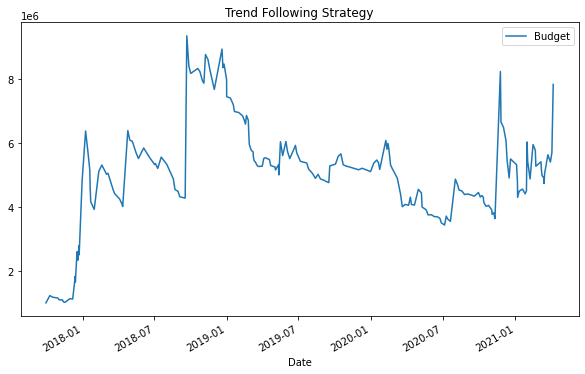

In [27]:
backtester_chandelier("KRW-ETH", "minute240", 20, 10, 3, 0.8, 0.2, '2017-09-26 17:00:00', '2021-04-08 01:00:00')